In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Local Spark App") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")


In [3]:
spark


In [4]:
# Import necessary libraries
import time
import logging
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, col, lower, to_timestamp, round, dayofweek, when, count
from pyspark.sql.functions import sum as _sum
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS

In [5]:
# Set up logging for monitoring
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
# Initialize Spark session
spark = SparkSession.builder.appName("SpotifyETL").getOrCreate()
logger.info("Spark session initialized")

2025-05-18 10:32:50,639 - INFO - Spark session initialized


In [ ]:
#  Load the CSV file
start_time = time.time()
logger.info("Loading spotify_history.csv")
try:
    df = spark.read.format("csv").option("header", "true").load("spotify_history.csv")
    logger.info(f"CSV loaded successfully. Number of partitions: {df.rdd.getNumPartitions()}")
except Exception as e:
    logger.error(f"Error loading CSV: {e}")
    raise
logger.info(f"Cell 1 execution time: {time.time() - start_time:.2f} seconds")

2025-05-18 10:32:51,305 - INFO - Loading spotify_history.csv
2025-05-18 10:32:54,499 - INFO - CSV loaded successfully. Number of partitions: 6
2025-05-18 10:32:54,499 - INFO - Cell 1 execution time: 3.19 seconds


In [8]:
logger.info("Counting rows to force a Spark job")
row_count = df.count()
logger.info(f"Total rows in DataFrame: {row_count}")

2025-05-18 10:32:54,503 - INFO - Counting rows to force a Spark job
2025-05-18 10:32:55,194 - INFO - Total rows in DataFrame: 149860


In [9]:
#  Basic inspection and repartition
start_time = time.time()
logger.info("Performing basic inspection and repartitioning")
try:
    df.show(5)
    df.printSchema()
    df = df.repartition(8)
    logger.info(f"Repartitioned DataFrame. Number of partitions: {df.rdd.getNumPartitions()}")
except Exception as e:
    logger.error(f"Error in inspection/repartition: {e}")
    raise
logger.info(f"Cell 2 execution time: {time.time() - start_time:.2f} seconds")

2025-05-18 10:32:55,203 - INFO - Performing basic inspection and repartitioning


+--------------------+-------------------+----------+---------+--------------------+-----------------+--------------------+------------+----------+-------+-------+
|   spotify_track_uri|                 ts|  platform|ms_played|          track_name|      artist_name|          album_name|reason_start|reason_end|shuffle|skipped|
+--------------------+-------------------+----------+---------+--------------------+-----------------+--------------------+------------+----------+-------+-------+
|2J3n32GeLmMjwuAzy...|2013-07-08 02:44:34|web player|     3185| Say It, Just Say It|     The Mowgli's|Waiting For The Dawn|    autoplay|  clickrow|  FALSE|  FALSE|
|1oHxIPqJyvAYHy0PV...|2013-07-08 02:45:37|web player|    61865|Drinking from the...|    Calvin Harris|           18 Months|    clickrow|  clickrow|  FALSE|  FALSE|
|487OPlneJNni3NWC8...|2013-07-08 02:50:24|web player|   285386|         Born To Die|     Lana Del Rey|Born To Die - The...|    clickrow|   unknown|  FALSE|  FALSE|
|5IyblF777jLZj1v

2025-05-18 10:32:56,119 - INFO - Repartitioned DataFrame. Number of partitions: 8
2025-05-18 10:32:56,124 - INFO - Cell 2 execution time: 0.92 seconds


In [10]:
#  Drop nulls in critical fields
start_time = time.time()
logger.info("Dropping nulls in critical fields")
try:
    df = df.dropna(subset=["track_name", "artist_name", "ms_played", "ts"])
    logger.info("Nulls dropped successfully")
except Exception as e:
    logger.error(f"Error dropping nulls: {e}")
    raise
logger.info(f"Cell 3 execution time: {time.time() - start_time:.2f} seconds")

2025-05-18 10:32:56,129 - INFO - Dropping nulls in critical fields
2025-05-18 10:32:56,152 - INFO - Nulls dropped successfully
2025-05-18 10:32:56,152 - INFO - Cell 3 execution time: 0.02 seconds


In [11]:
#  Remove duplicates
start_time = time.time()
logger.info("Removing duplicates")
try:
    df = df.dropDuplicates()
    logger.info("Duplicates removed successfully")
except Exception as e:
    logger.error(f"Error removing duplicates: {e}")
    raise
logger.info(f"Cell 4 execution time: {time.time() - start_time:.2f} seconds")

2025-05-18 10:32:56,159 - INFO - Removing duplicates
2025-05-18 10:32:56,168 - INFO - Duplicates removed successfully
2025-05-18 10:32:56,168 - INFO - Cell 4 execution time: 0.01 seconds


In [12]:
#  Clean text fields
start_time = time.time()
logger.info("Cleaning text fields")
try:
    df = df.withColumn("track_name", trim(col("track_name")))
    df = df.withColumn("artist_name", trim(col("artist_name")))
    df = df.withColumn("album_name", trim(col("album_name")))
    df = df.withColumn("platform", trim(col("platform")))
    logger.info("Text fields cleaned successfully")
except Exception as e:
    logger.error(f"Error cleaning text fields: {e}")
    raise
logger.info(f"Cell 5 execution time: {time.time() - start_time:.2f} seconds")

2025-05-18 10:32:56,177 - INFO - Cleaning text fields
2025-05-18 10:32:56,235 - INFO - Text fields cleaned successfully
2025-05-18 10:32:56,235 - INFO - Cell 5 execution time: 0.06 seconds


In [13]:
#  Convert timestamp and create minutes_played column
start_time = time.time()
logger.info("Converting timestamp and creating minutes_played column")
try:
    df = df.withColumn("timestamp", to_timestamp("ts"))
    df = df.withColumn("minutes_played", round(col("ms_played") / 60000, 2))
    df.createOrReplaceTempView("spotify_cleaned")
    logger.info("Timestamp converted and minutes_played column created")
except Exception as e:
    logger.error(f"Error in timestamp conversion or column creation: {e}")
    raise
logger.info(f"Cell 6 execution time: {time.time() - start_time:.2f} seconds")

2025-05-18 10:32:57,051 - INFO - Converting timestamp and creating minutes_played column
2025-05-18 10:32:57,134 - INFO - Timestamp converted and minutes_played column created
2025-05-18 10:32:57,134 - INFO - Cell 6 execution time: 0.08 seconds


In [14]:
#  Preview the cleaned data
print("Table: Preview of Cleaned Data (First 10 Rows)")
df.show(10)


Table: Preview of Cleaned Data (First 10 Rows)
+--------------------+-------------------+--------------+---------+--------------------+--------------------+--------------------+------------+----------+-------+-------+-------------------+--------------+
|   spotify_track_uri|                 ts|      platform|ms_played|          track_name|         artist_name|          album_name|reason_start|reason_end|shuffle|skipped|          timestamp|minutes_played|
+--------------------+-------------------+--------------+---------+--------------------+--------------------+--------------------+------------+----------+-------+-------+-------------------+--------------+
|7IWkJwX9C0J7tHurT...|2017-04-06 13:48:14|       android|   279842|  When We Were Young|               Adele|                  25|      fwdbtn|    logout|   TRUE|  FALSE|2017-04-06 13:48:14|          4.66|
|4iZPNYqzI2L0uwuUK...|2015-08-25 00:03:07|       android|     4643|      Stole the Show|                Kygo|      Stole the Show

In [15]:
# Load and preprocess data (same as previous steps)
df = spark.read.format("csv").option("header", "true").load("spotify_history.csv")
df = df.dropna(subset=["track_name", "artist_name", "ms_played","ts"])
df = df.withColumn("timestamp", col("ts").cast("timestamp"))
df = df.withColumn("minutes_played", (col("ms_played").cast("double") / 60000).cast("double"))

In [ ]:
#  Count plays per platform
platform_usage = df.groupBy("platform").count().orderBy("count", ascending=False)
platform_usage_pd = platform_usage.toPandas()
# Table for Cell 9
print("Table: Plays per Platform")
platform_usage.show()

Table: Plays per Platform
+--------------+------+
|      platform| count|
+--------------+------+
|       android|139821|
|cast to device|  3898|
|           iOS|  3049|
|       windows|  1691|
|           mac|  1176|
|    web player|   225|
+--------------+------+



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

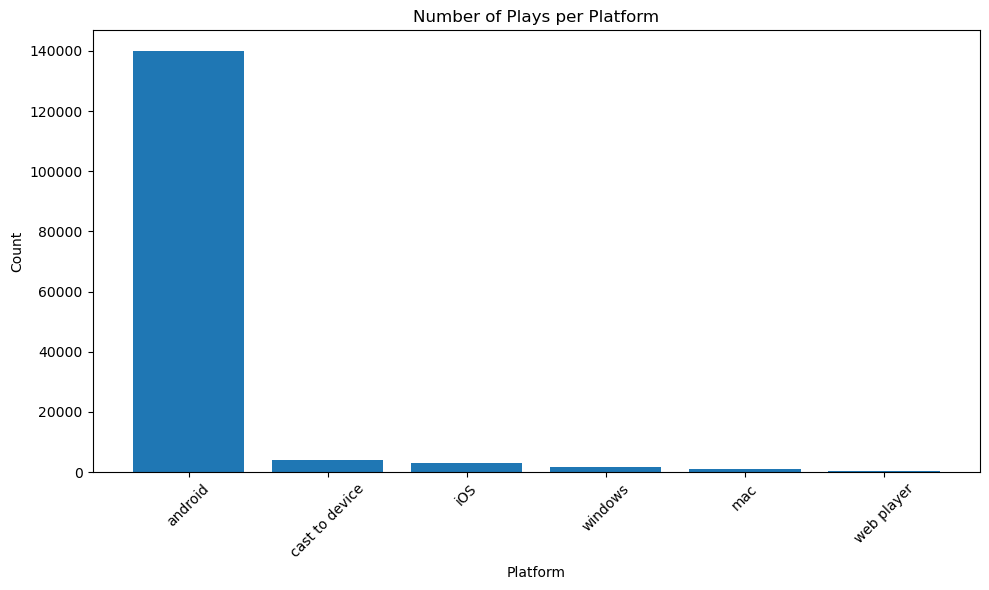

In [17]:
# Visualization for 
plt.figure(figsize=(10, 6))
plt.bar(platform_usage_pd["platform"], platform_usage_pd["count"])
plt.title("Number of Plays per Platform")
plt.xlabel("Platform")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
#  Analyze skip rate with counts
shuffle_skips = df.groupBy("shuffle").agg(
    count(when(col("skipped") == "true", True)).alias("skipped"),
    count("*").alias("total")
).withColumn("skip_rate", col("skipped") / col("total"))
shuffle_skips_pd = shuffle_skips.toPandas()

C:\Users\Sagda\AppData\Local\Temp\ipykernel_4592\2160063059.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(shuffle_skips_pd["shuffle"], rotation=45)


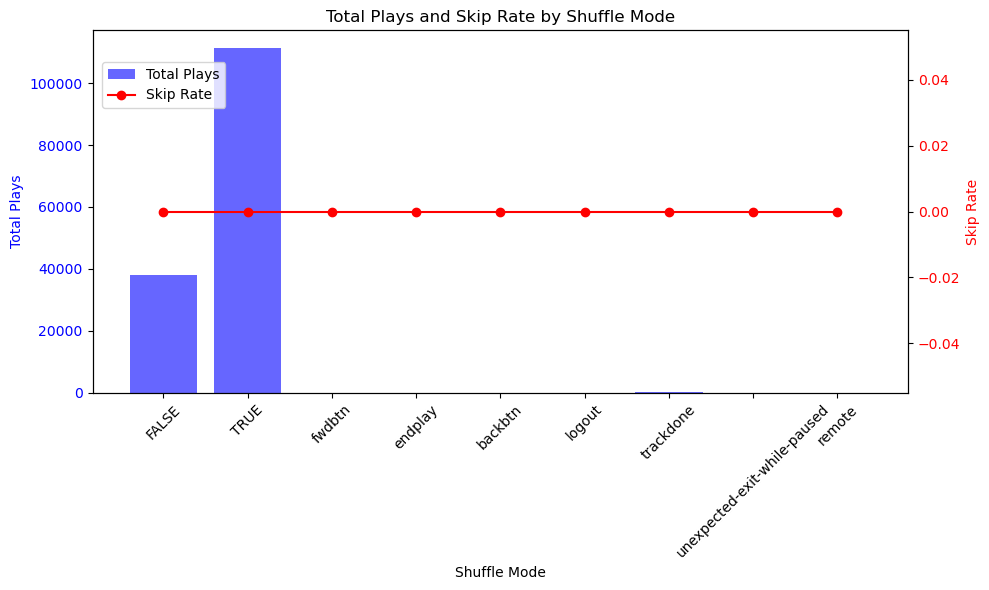

In [ ]:
# Visualization 
import matplotlib.pyplot as plt

# Create figure and axis using plt.subplots()
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total plays as bars on the first axis
ax1.bar(shuffle_skips_pd["shuffle"], shuffle_skips_pd["total"], color='b', alpha=0.6, label='Total Plays')
ax1.set_xlabel("Shuffle Mode")
ax1.set_ylabel("Total Plays", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for skip rate
ax2 = ax1.twinx()
ax2.plot(shuffle_skips_pd["shuffle"], shuffle_skips_pd["skip_rate"], color='r', marker='o', label='Skip Rate')
ax2.set_ylabel("Skip Rate", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set title and rotate x-axis labels
plt.title("Total Plays and Skip Rate by Shuffle Mode")
ax1.set_xticklabels(shuffle_skips_pd["shuffle"], rotation=45)

# Add a legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
# Table for
print("Table: Skip Rate with Counts by Shuffle Mode")
shuffle_skips.show()

Table: Skip Rate with Counts by Shuffle Mode
+--------------------+-------+------+---------+
|             shuffle|skipped| total|skip_rate|
+--------------------+-------+------+---------+
|               FALSE|      0| 38141|      0.0|
|                TRUE|      0|111465|      0.0|
|              fwdbtn|      0|    50|      0.0|
|             endplay|      0|    10|      0.0|
|             backbtn|      0|    10|      0.0|
|              logout|      0|    10|      0.0|
|           trackdone|      0|   172|      0.0|
|unexpected-exit-w...|      0|     1|      0.0|
|              remote|      0|     1|      0.0|
+--------------------+-------+------+---------+



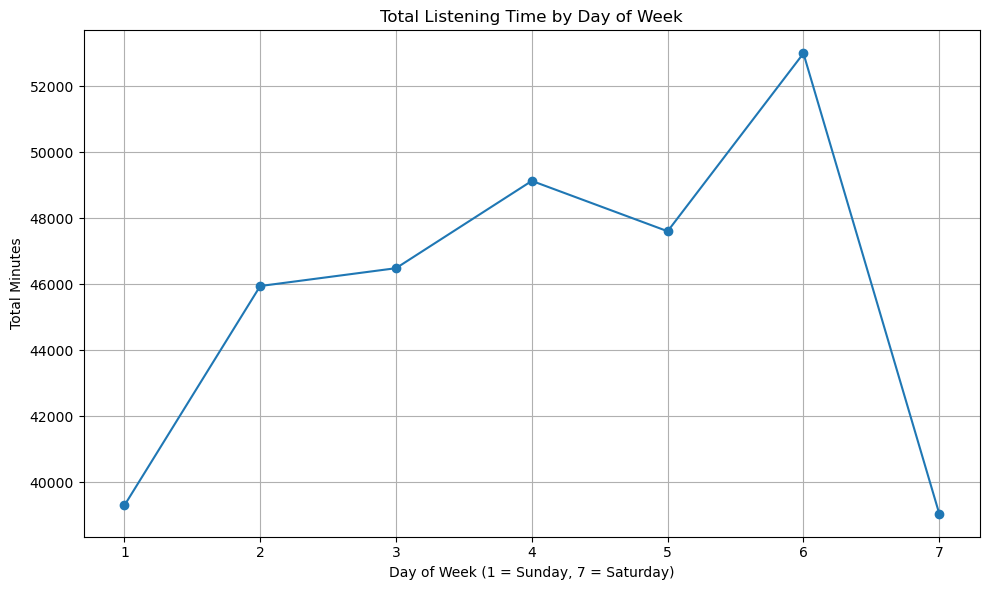

Table: Total Listening Time by Day of Week
+-----------+------------------+
|day_of_week|     total_minutes|
+-----------+------------------+
|          1|39290.869733333275|
|          2| 45943.44621666663|
|          3| 46484.34633333335|
|          4| 49130.96175000001|
|          5| 47604.17765000002|
|          6| 52998.10000000007|
|          7| 39040.28056666664|
+-----------+------------------+



In [22]:
#  Weekly listening patterns
# Import necessary libraries (ensure these are already imported)
from pyspark.sql.functions import dayofweek, col, sum as _sum
import matplotlib.pyplot as plt

# Assuming df is already defined from previous cells
# Ensure the timestamp conversion is applied correctly
df = df.withColumn("timestamp", col("ts").cast("timestamp"))

# Cell 12: Weekly listening patterns
# Use the 'timestamp' column (which is already cast to TimestampType) for dayofweek
df_with_day = df.withColumn("day_of_week", dayofweek(col("timestamp")))
listening_by_day = (df_with_day.groupBy("day_of_week")
                   .agg(_sum("minutes_played").alias("total_minutes"))
                   .orderBy("day_of_week"))

# Convert to Pandas DataFrame
listening_by_day_pd = listening_by_day.toPandas()

# Check if the DataFrame is empty or has invalid data
if listening_by_day_pd.empty:
    print("Error: listening_by_day_pd DataFrame is empty. Cannot plot.")
else:
    # Ensure total_minutes is numeric
    listening_by_day_pd["total_minutes"] = pd.to_numeric(listening_by_day_pd["total_minutes"], errors='coerce')
    if listening_by_day_pd["total_minutes"].isnull().any():
        print("Warning: Some total_minutes values are non-numeric and will be ignored.")

    # Visualization for Cell 12
    plt.figure(figsize=(10, 6))
    plt.plot(listening_by_day_pd["day_of_week"], listening_by_day_pd["total_minutes"], marker='o')
    plt.title("Total Listening Time by Day of Week")
    plt.xlabel("Day of Week (1 = Sunday, 7 = Saturday)")
    plt.ylabel("Total Minutes")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display table
print("Table: Total Listening Time by Day of Week")
listening_by_day.show()

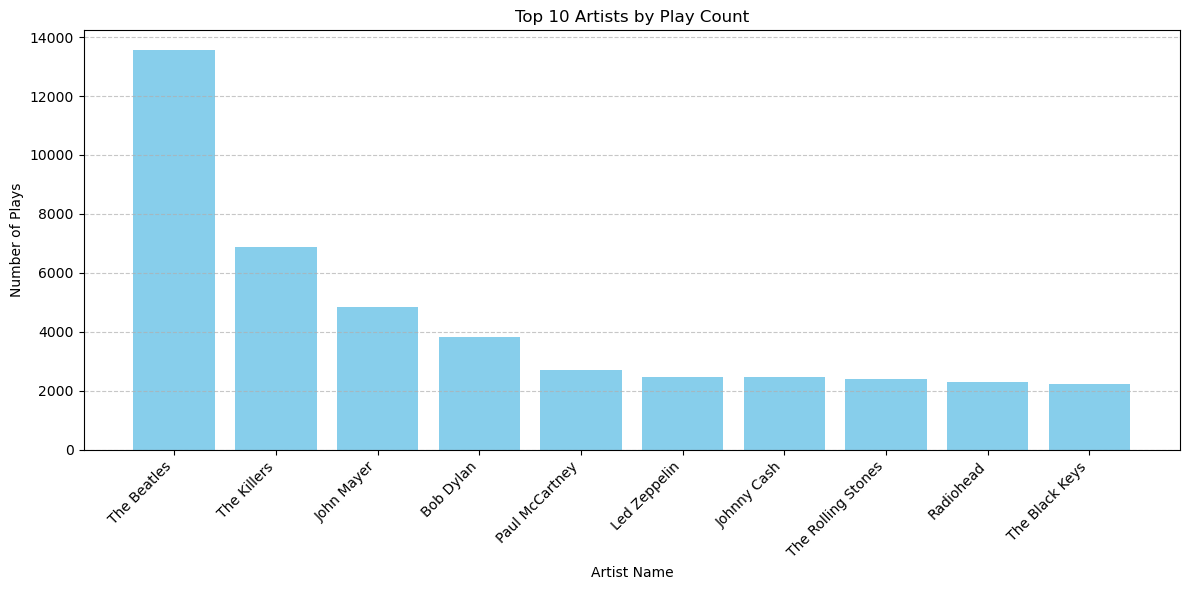

Table: Artist Play Counts
+------------------+-----+
|       artist_name|count|
+------------------+-----+
|       The Beatles|13550|
|       The Killers| 6878|
|        John Mayer| 4855|
|         Bob Dylan| 3814|
|    Paul McCartney| 2697|
|      Led Zeppelin| 2482|
|       Johnny Cash| 2478|
|The Rolling Stones| 2390|
|         Radiohead| 2305|
|    The Black Keys| 2231|
+------------------+-----+
only showing top 10 rows



In [23]:
#  Count Artist Appearances
# Purpose: Find which artists are played most frequently (not based on duration)
import matplotlib.pyplot as plt
import pandas as pd

artist_counts = df.groupBy("artist_name").count().orderBy("count", ascending=False)
artist_counts_pd = artist_counts.toPandas()

# Check if DataFrame is empty
if artist_counts_pd.empty:
    print("Error: artist_counts_pd DataFrame is empty. Cannot plot.")
else:
    # Visualization for Cell 10
    plt.figure(figsize=(12, 6))
    plt.bar(artist_counts_pd['artist_name'].head(10), artist_counts_pd['count'].head(10), color='skyblue')
    plt.title("Top 10 Artists by Play Count")
    plt.xlabel("Artist Name")
    plt.ylabel("Number of Plays")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Table: Artist Play Counts")
artist_counts.show(10) # Show top 10 artists

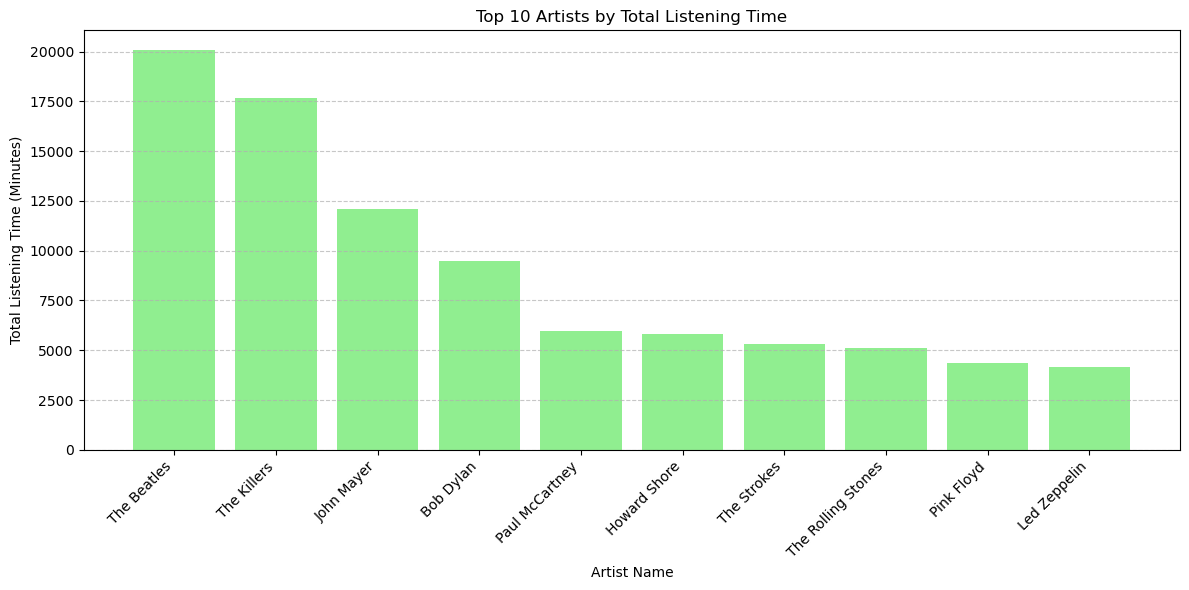

Table: Artist Total Listening Time
+------------------+------------------+
|       artist_name|     total_minutes|
+------------------+------------------+
|       The Beatles|20060.392350000006|
|       The Killers|17659.275266666707|
|        John Mayer|12086.990716666645|
|         Bob Dylan| 9490.939933333337|
|    Paul McCartney|5955.9061666666685|
|      Howard Shore| 5815.511250000004|
|       The Strokes| 5291.806983333337|
|The Rolling Stones|5131.9501500000015|
|        Pink Floyd| 4342.197366666669|
|      Led Zeppelin| 4138.971316666666|
+------------------+------------------+
only showing top 10 rows



In [24]:
# Group by Artist and Calculate Total Listening Time
# Purpose: Identify which artists users spend the most time listening to
import matplotlib.pyplot as plt
import pandas as pd

artist_total_time = df.groupBy("artist_name") \
    .agg(_sum("minutes_played").alias("total_minutes")) \
    .orderBy("total_minutes", ascending=False)
artist_total_time_pd = artist_total_time.toPandas()

# Check if DataFrame is empty
if artist_total_time_pd.empty:
    print("Error: artist_total_time_pd DataFrame is empty. Cannot plot.")
else:
    # Visualization for Cell 11
    plt.figure(figsize=(12, 6))
    plt.bar(artist_total_time_pd['artist_name'].head(10), artist_total_time_pd['total_minutes'].head(10), color='lightgreen')
    plt.title("Top 10 Artists by Total Listening Time")
    plt.xlabel("Artist Name")
    plt.ylabel("Total Listening Time (Minutes)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Table: Artist Total Listening Time")
artist_total_time.show(10) # Show top 10 artists by time

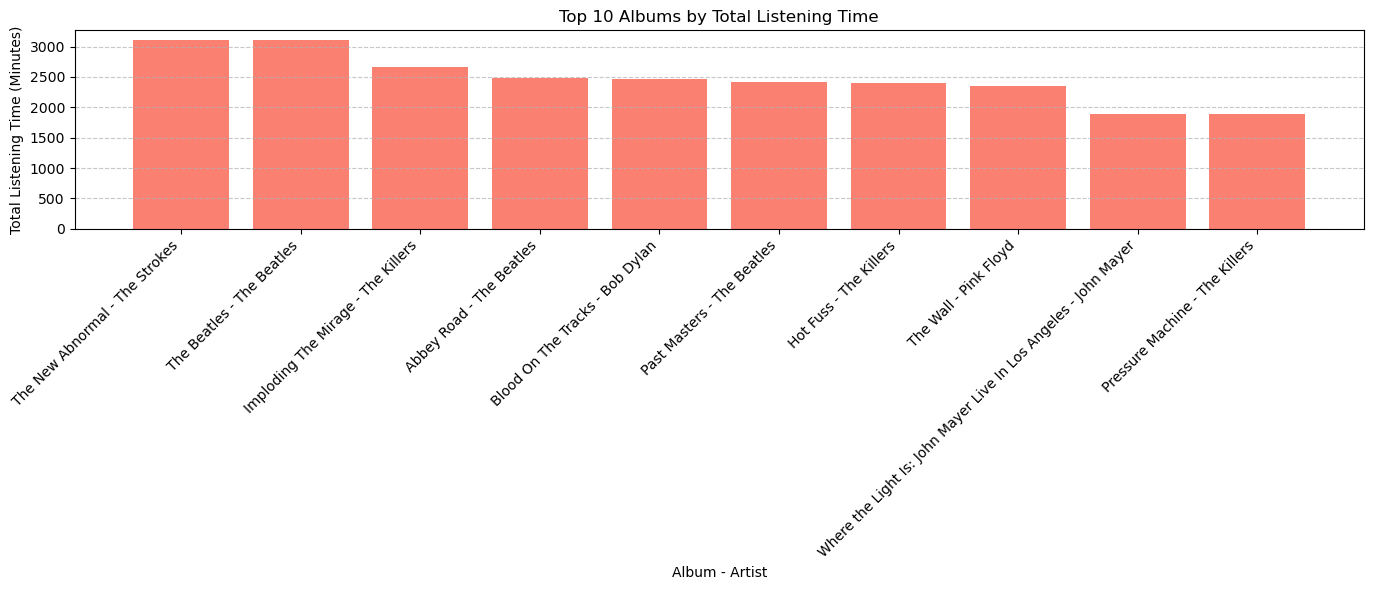

Table: Album Listening Time
+--------------------+-----------+------------------+
|          album_name|artist_name|     total_minutes|
+--------------------+-----------+------------------+
|    The New Abnormal|The Strokes|3112.6315833333347|
|         The Beatles|The Beatles| 3110.821600000003|
|Imploding The Mirage|The Killers| 2665.389349999995|
|          Abbey Road|The Beatles|2477.0051666666654|
| Blood On The Tracks|  Bob Dylan|2464.8170833333315|
|        Past Masters|The Beatles|2417.0679333333337|
|            Hot Fuss|The Killers|2407.4587333333325|
|            The Wall| Pink Floyd| 2351.756899999999|
|Where the Light I...| John Mayer| 1896.900016666666|
|    Pressure Machine|The Killers| 1888.740066666666|
+--------------------+-----------+------------------+
only showing top 10 rows



In [25]:
# Group by Album and Artist, Sum Listening Time
# Purpose: Understand which albums have the most engagement
import matplotlib.pyplot as plt
import pandas as pd

album_artist_time = df.groupBy("album_name", "artist_name") \
    .agg(_sum("minutes_played").alias("total_minutes")) \
    .orderBy("total_minutes", ascending=False)
album_artist_time_pd = album_artist_time.toPandas()

# Check if DataFrame is empty
if album_artist_time_pd.empty:
    print("Error: album_artist_time_pd DataFrame is empty. Cannot plot.")
else:
    # Create a combined label for album and artist
    album_artist_time_pd['album_artist'] = album_artist_time_pd['album_name'] + ' - ' + album_artist_time_pd['artist_name']

    # Visualization for Cell 12
    plt.figure(figsize=(14, 6))
    plt.bar(album_artist_time_pd['album_artist'].head(10), album_artist_time_pd['total_minutes'].head(10), color='salmon')
    plt.title("Top 10 Albums by Total Listening Time")
    plt.xlabel("Album - Artist")
    plt.ylabel("Total Listening Time (Minutes)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Table: Album Listening Time")
album_artist_time.show(10) # Show top 10 albums

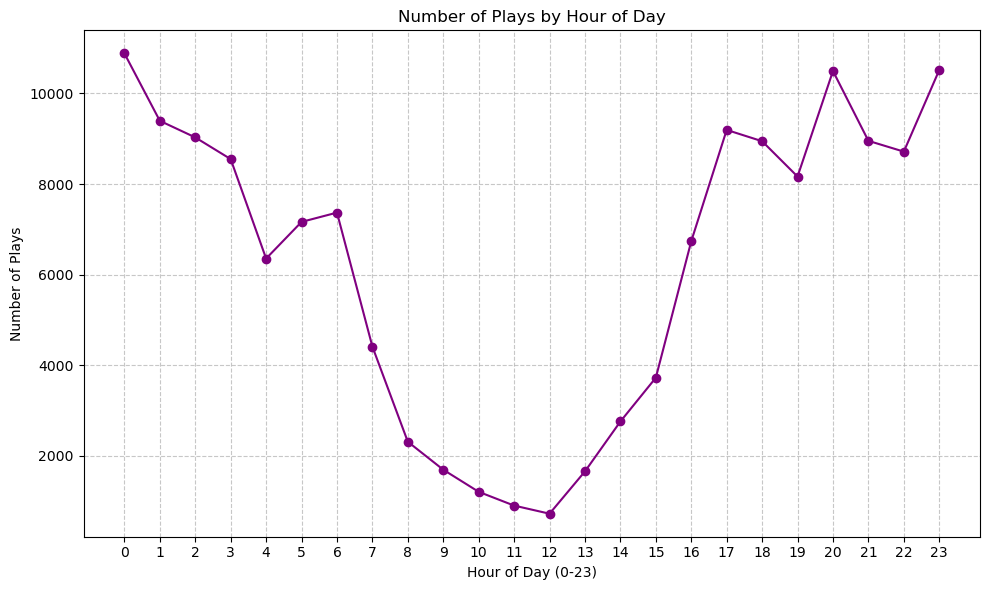

Table: Hourly Play Counts
+----+-----+
|hour|count|
+----+-----+
|   0|10884|
|   1| 9395|
|   2| 9029|
|   3| 8550|
|   4| 6355|
|   5| 7164|
|   6| 7369|
|   7| 4412|
|   8| 2312|
|   9| 1695|
|  10| 1207|
|  11|  903|
|  12|  724|
|  13| 1658|
|  14| 2759|
|  15| 3725|
|  16| 6737|
|  17| 9194|
|  18| 8945|
|  19| 8165|
|  20|10494|
|  21| 8953|
|  22| 8715|
|  23|10516|
+----+-----+



In [ ]:
# Group by Hour of Day and Count Plays
# Purpose: Identify when users are most active during the day
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import pandas as pd

hourly_plays = df.groupBy(hour("timestamp").alias("hour")) \
    .count() \
    .orderBy("hour")
hourly_plays_pd = hourly_plays.toPandas()

# Check if DataFrame is empty
if hourly_plays_pd.empty:
    print("Error: hourly_plays_pd DataFrame is empty. Cannot plot.")
else:
    # Visualization for Cell 13
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_plays_pd['hour'], hourly_plays_pd['count'], marker='o', color='purple')
    plt.title("Number of Plays by Hour of Day")
    plt.xlabel("Hour of Day (0-23)")
    plt.ylabel("Number of Plays")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, 24))  # Ensure all hours are shown
    plt.tight_layout()
    plt.show()

print("Table: Hourly Play Counts")
hourly_plays.show(24) # Show counts for each hour

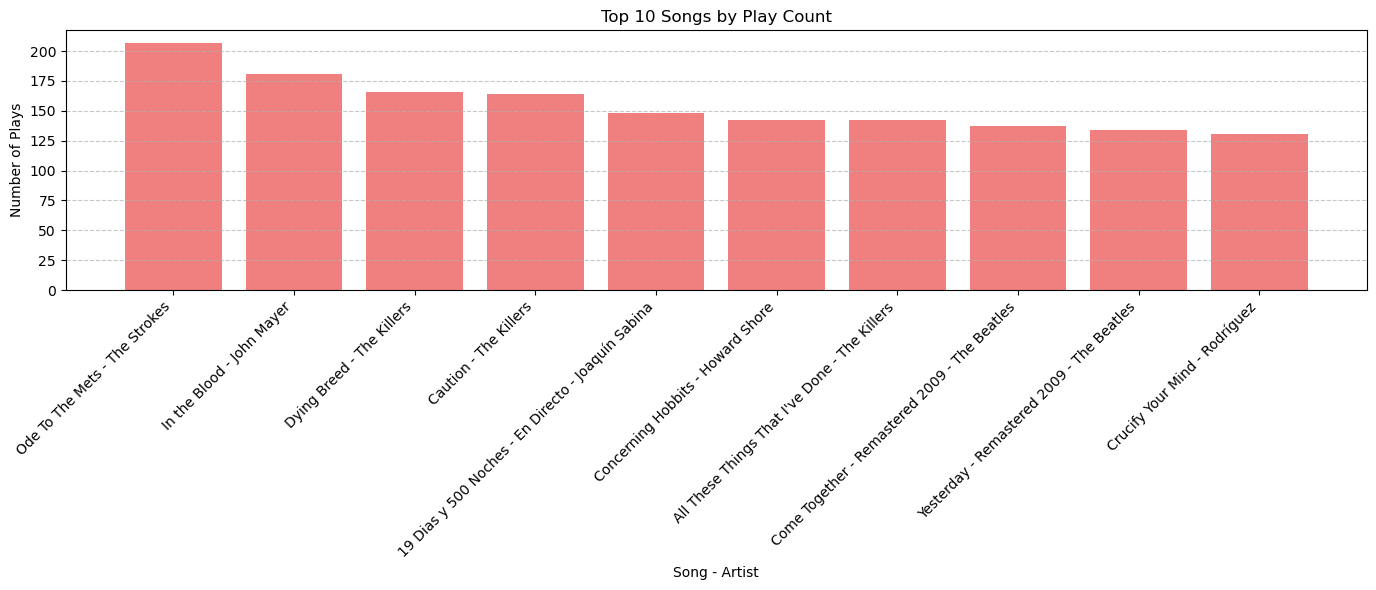

Table: Song Play Counts
+--------------------+--------------+-----+
|          track_name|   artist_name|count|
+--------------------+--------------+-----+
|     Ode To The Mets|   The Strokes|  207|
|        In the Blood|    John Mayer|  181|
|         Dying Breed|   The Killers|  166|
|             Caution|   The Killers|  164|
|19 Dias y 500 Noc...|Joaquín Sabina|  148|
|  Concerning Hobbits|  Howard Shore|  142|
|All These Things ...|   The Killers|  142|
|Come Together - R...|   The Beatles|  137|
|Yesterday - Remas...|   The Beatles|  134|
|   Crucify Your Mind|     Rodríguez|  131|
+--------------------+--------------+-----+
only showing top 10 rows



In [ ]:
#  Count Song Appearances
# Purpose: Detect highly repeated songs (hits or user favorites)
import matplotlib.pyplot as plt
import pandas as pd

song_counts = df.groupBy("track_name", "artist_name").count().orderBy("count", ascending=False)
song_counts_pd = song_counts.toPandas()

# Check if DataFrame is empty
if song_counts_pd.empty:
    print("Error: song_counts_pd DataFrame is empty. Cannot plot.")
else:
    # Create a combined label for track and artist
    song_counts_pd['track_artist'] = song_counts_pd['track_name'] + ' - ' + song_counts_pd['artist_name']

    # Visualization for Cell 14
    plt.figure(figsize=(14, 6))
    plt.bar(song_counts_pd['track_artist'].head(10), song_counts_pd['count'].head(10), color='lightcoral')
    plt.title("Top 10 Songs by Play Count")
    plt.xlabel("Song - Artist")
    plt.ylabel("Number of Plays")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Table: Song Play Counts")
song_counts.show(10) # Show top 10 songs

In [ ]:
#  Prepare Data for ALS
# Purpose:  Transform data into the format required by the ALS algorithm.
#           This involves numerical encoding of users (in this case, artists) and items (tracks).

from pyspark.ml.feature import StringIndexer

# Create user and track IDs
artist_indexer = StringIndexer(inputCol="artist_name", outputCol="artist_id")
track_indexer = StringIndexer(inputCol="track_name", outputCol="track_id")

# Fit and transform the data
df_indexed = artist_indexer.fit(df).transform(df)
df_indexed = track_indexer.fit(df_indexed).transform(df_indexed)

# Select relevant columns and create a ratings-like table
als_data = df_indexed.select("artist_id", "track_id", "minutes_played")

# Display the prepared data
print("Prepared data for ALS:")
als_data.show(5)

Prepared data for ALS:
+---------+--------+-------------------+
|artist_id|track_id|     minutes_played|
+---------+--------+-------------------+
|   3925.0| 11888.0|0.05308333333333334|
|    448.0|  5424.0| 1.0310833333333334|
|    288.0|  3726.0|  4.756433333333334|
|    288.0| 11166.0|             2.2337|
|    177.0|  9280.0|                0.0|
+---------+--------+-------------------+
only showing top 5 rows



In [ ]:
# Split Data into Training and Test Sets
# Purpose:   Divide the data to evaluate the recommendation model's performance.
#            A portion is used to train the model, and the rest to test its predictions.

# Split the data into training and test sets (e.g., 80% train, 20% test)
(training, test) = als_data.randomSplit([0.8, 0.2], seed=42)  # Seed for reproducibility

# Display the size of each set
print(f"Training set size: {training.count()}")
print(f"Test set size: {test.count()}")

Training set size: 120077
Test set size: 29783


In [ ]:
#  Train the ALS Recommendation Model
# Purpose:   Build the recommendation model using the Alternating Least Squares (ALS) algorithm.
#            Key parameters (rank, maxIter) are set to control the model's complexity and training process.

from pyspark.ml.recommendation import ALS

# Build the ALS model
als = ALS(maxIter=10, regParam=0.01, userCol="artist_id", itemCol="track_id", ratingCol="minutes_played",
          coldStartStrategy="drop") # Drop rows with nulls in user or item cols

# Train the model with the training data
model = als.fit(training)

print("ALS model trained.")

ALS model trained.


In [ ]:
# Evaluate the Model
# Purpose:   Assess how well the model predicts user preferences on the test data.
#            Root Mean Squared Error (RMSE) is a common metric for evaluating recommendation accuracy.

from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test data
predictions = model.transform(test)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="minutes_played", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.4f}")

# Clean up predictions (remove NaN)
predictions = predictions.dropna(subset=["prediction"])

Root Mean Squared Error (RMSE) on test data: 1.7389


In [ ]:
# Generate Recommendations for a User
# Purpose:   Show how to use the trained model to provide personalized recommendations.
#            This example generates the top 10 track recommendations for a specific artist.

# Define the user (artist_id) for whom to generate recommendations
sample_artist_id = 10  # Replace with a valid artist_id from your data

# Generate top 10 track recommendations for the selected user
top_recommendations = model.recommendForUserSubset(spark.createDataFrame([(sample_artist_id,)], ["artist_id"]), 10)

# Display the recommendations (requires further processing to map track_ids back to track_names)
print(f"Top 10 recommendations for artist_id {sample_artist_id}:")
top_recommendations.show(truncate=False)

Top 10 recommendations for artist_id 10:
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artist_id|recommendations                                                                                                                                                                          |
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10       |[{12054, 5.6119533}, {7718, 5.461796}, {3842, 5.338541}, {12832, 5.333663}, {3461, 4.766957}, {10782, 4.670929}, {3796, 4.365481}, {9010, 4.2872334}, {8963, 4.286561}, {7360, 4.224811}]|
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------